In [1]:
import os
import h5py
import numpy as np
import rasterio as rio
import matplotlib.pyplot as plt
from skimage.segmentation import find_boundaries
from matplotlib.collections import PatchCollection
from descartes import PolygonPatch
from shapely.geometry import shape, LineString
from scipy.ndimage import measurements

from modis_utils.misc import restore_data, cache_data
from modis_utils.image_processing import mask_lake_img

/usr/local/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [3]:
data_dir = '../simple_63/predict/ALL/0/NDVI/normalized_div/50/1/64/convlstm_simple/test'

In [4]:
import pickle
def restore_data_pickle(path):
    with open(path, 'rb') as f:
        data = pickle.load(f)
        return data
    
def cache_data_pickle(data, path):
    with open(path, 'wb') as f:
        pickle.dump(data, f)

In [7]:
def get_boundary(data_dir, idx):
    path = os.path.join(data_dir, '{}.dat'.format(idx))
    data = restore_data(path)
    mask_lake = mask_lake_img(data, offset=0.1)
    boundary = find_boundaries(mask_lake)
    return boundary

In [8]:
a = get_boundary(data_dir, 0)

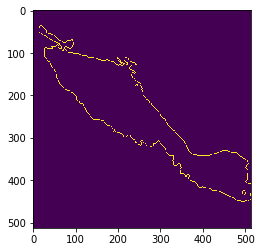

In [9]:
plt.imshow(a)

In [10]:
groundtruth_dir = 'boundaries_matrix'
groundtruth_train = restore_data(os.path.join(groundtruth_dir, 'train.dat'))
groundtruth_val = restore_data(os.path.join(groundtruth_dir, 'val.dat'))
groundtruth_test = restore_data(os.path.join(groundtruth_dir, 'test.dat'))

In [11]:
def boundary_loss_np(groundtruth, predict):
    groundtruth = groundtruth.astype(np.float)
    predict = predict.astype(np.float)
    square_error = (groundtruth - predict)**2
    return np.sum(np.multiply(groundtruth, square_error)) / np.sum(groundtruth)

In [12]:
groundtruth_test.shape

(138, 513, 513)

In [13]:
convlstm_loss = []
for i in range(len(groundtruth_test)):
    convlstm_boundary = get_boundary(data_dir, i)
    groundtruth_boundary = groundtruth_test[i]
    convlstm_loss.append(boundary_loss_np(groundtruth_boundary, convlstm_boundary))

In [14]:
np.mean(convlstm_loss)

0.6777498435537611